# Load Modules

In [559]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print("file_dir: -> ",file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

file_dir: ->  C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [299]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import (
    boxplot_histogram,
    clean_up_categoricals
    )
from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx
    )
from pa_lib.util import (
    cap_words
    
    )                     

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 300


In [23]:
from pa_lib.data import desc_col

In [138]:
## Lazy Recursive Job Dependency Request:
from pa_lib.job import request_job

################################################################################
## Recursive Dependency Check:
request_job(job_name="bd_prepare.py",  current= "Today") # output: bd_data.feather

15:34:07 [INFO] [ipykernel_launcher.py] requests 'bd_prepare.py'
15:34:07 [INFO] [ipykernel_launcher.py]: Not running job 'bd_prepare.py': result is current ('Today') from 2019-11-05 15:27:15.887908.


# Load Datasets

In [659]:
def load_ek_list_rscript(file):
    raw_text            = open("C:\\Users\stc\data\\vkprog\\predictions\\"+file,"r")
    text_row_list       = raw_text.readlines()
    
    text_single_entries = [x.replace("\n","").split(';') for x in text_row_list]
    
    subselect_list      = [x[0:18] + x[-57:] for x in text_single_entries]
    
    pred_rscript_raw    = pd.DataFrame(data    = subselect_list[1:],
                                       columns = subselect_list[0]
                                      )
    
    prob_col   = [col for col in pred_rscript_raw.columns if col.startswith("prob_KW")]
    col_select = ["ENDKUNDE_NR","Endkunde"] + prob_col
    
    row_select = ((pred_rscript_raw
                  .loc[:,"ENDKUNDE_NR"]
                  .map(lambda x: str(x).isdigit())
                 ) &
                  (pred_rscript_raw
                  .loc[:,prob_col[0]]
                  .map(lambda x: str(x).replace('.','').isdigit())
                 )
                  
                 )
    
    ek_list_rscript = (pred_rscript_raw
            .loc[row_select,col_select]
            .rename(columns={"ENDKUNDE_NR": "Endkunde_NR",
                            prob_col[0]: "Prob_rscript"})
            .astype({"Endkunde_NR": "int64",
                    "Prob_rscript": "float64"})
           )
    
    print(ek_list_rscript.shape)
    
    return ek_list_rscript

In [664]:
with project_dir("vkprog\\predictions"):
    #pred_rebuild_df = load_bin("20190701_pred_rebuild.feather")
    pred_rebuild_df = load_bin("20190701_pred_rebuild_without_sales_filter.feather")
    
    """pred_rscript_df_raw = load_xlsx("20190701_EK_LIST_2W_KOMPLETT.xlsx")
    
    row_select = (pred_rscript_df_raw
                  .loc[:,"ENDKUNDE_NR"]
                  .map(lambda x: str(x).isdigit())
                 )
    
    pred_rscript_df = (
        pred_rscript_df_raw
        .loc[row_select,:]
        .astype({"ENDKUNDE_NR": "int64"})
        .rename(columns={"ENDKUNDE_NR": "Endkunde_NR"})
        )
    
    del pred_rscript_df_raw"""

with project_dir("vkprog"):
    
    # Booking data:
    bd_raw = load_bin("bd_data.feather").rename(
        mapper=lambda name: cap_words(name, sep="_"), axis="columns"
    )
    bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)
    del bd_raw # not needed anymore
    
    # List of active Vkber:
    vkprog_raw = load_csv("vkber_data.csv")
    
pred_rscript_df_raw = load_ek_list_rscript("20190701_EK_LIST_2W_KOMPLETT.csv")

18:14:39 [INFO] Started loading binary file
18:14:39 [INFO] Reading from file C:\Users\stc\data\vkprog\predictions\20190701_pred_rebuild_without_sales_filter.feather
18:14:39 [INFO] Finished loading binary file in 0.0s (0.03s CPU)
18:14:39 [INFO] Started loading binary file
18:14:39 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
18:14:40 [INFO] Finished loading binary file in 0.17s (0.88s CPU)
18:14:41 [INFO] Started loading CSV
18:14:41 [INFO] Reading from file C:\Users\stc\data\vkprog\vkber_data.csv
18:14:41 [INFO] Finished loading CSV in 0.0s (0.02s CPU)
(11675, 3)


## DWH Data (actual reservations)

In [666]:
def customer_netto(KW_2, year):
    row_select = (
        # No cancellations/ Annulationen:
        (bd.loc[:,"Kampagnen_Status"] != 3)    &
        
        # Which two week period:
        (bd.loc[:,"Kamp_Erfass_KW_2"] == KW_2) &
        
        # Which year:
        (bd.loc[:,"Kamp_Erfass_Jahr"] == year) &
        
        # Only profitable campaigns:
        (bd.loc[:,"Netto"] >0)
        )

    reality_df = (bd
        .loc[row_select,:]
        .groupby(["Endkunde_NR","Kamp_Erfass_Jahr","Kamp_Erfass_KW_2"])
        .agg({"Netto": np.nansum})
        .reset_index(inplace=False)
        )
    print(f"(year = {year}, KW_2 = {KW_2}), {reality_df.shape}")
    return reality_df

In [667]:
reality_2019_df = customer_netto(KW_2=27,year=2019)
reality_2018_df = customer_netto(KW_2=27,year=2018)

(year = 2019, KW_2 = 27), (621, 4)
(year = 2018, KW_2 = 27), (395, 4)


In [668]:
netto_sum_2018 = reality_2018_df.loc[:,"Netto"].sum()
print("Numbers from 2018, KW_2 == 45 :\n")
print(f"#Campaigns (Reservations):\n {reality_2018_df.shape[0]}")
print(f"Netto-Sum of Reservations:\n {netto_sum_2018}")


Numbers from 2018, KW_2 == 45 :

#Campaigns (Reservations):
 395
Netto-Sum of Reservations:
 8890023


# Combine Datasets

In [672]:
desc_col(pred_rscript_df_raw)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/11675,11675
Endkunde,object,0/11675,11191
Prob_rscript,float64,0/11675,312


In [676]:
comparision_df = (
    reality_2019_df
        #
        .merge(
            pred_rscript_df_raw
            .eval("Prob_rscript = Prob_rscript*0.01")
            .loc[:,["Endkunde_NR","Prob_rscript"]],
            on="Endkunde_NR",
            how="right"
        )
        .merge(
            pred_rebuild_df
            .loc[:,["Endkunde_NR","Prob_1"]],
            on="Endkunde_NR",
            how="inner"
        )
        .fillna(
            value={
                "Kamp_Erfass_Jahr": (reality_2019_df
                                     .loc[:,"Kamp_Erfass_Jahr"]
                                     .max()),
                "Kamp_Erfass_KW_2": (reality_2019_df
                                     .loc[:,"Kamp_Erfass_KW_2"]
                                     .min()),
                "Netto": 0,
                "Prob_rscript": 0,
            
            }
        )
    )
comparision_df.sample(5)

,Endkunde_NR,Kamp_Erfass_Jahr,Kamp_Erfass_KW_2,Netto,Prob_rscript,Prob_1
1827,651697,2019,27,0.0,0.036,0.190326
6372,625267,2019,27,0.0,0.016,0.144040
10816,625582,2019,27,0.0,0.005,0.070272
958,619539,2019,27,0.0,0.062,0.081012
2600,651125,2019,27,0.0,0.030,0.295547


In [678]:
display(desc_col(comparision_df))
display(comparision_df.describe())

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/11671,11671
Kamp_Erfass_Jahr,category,0/11671,1
Kamp_Erfass_KW_2,category,0/11671,1
Netto,float64,0/11671,312
Prob_rscript,float64,0/11671,312
Prob_1,float64,0/11671,11631


,Endkunde_NR,Netto,Prob_rscript,Prob_1
count,11671.000000,11671.000000,11671.000000,11671.000000
mean,491520.395339,550.473824,0.027946,0.226705
std,190940.060255,8633.384439,0.057594,0.138717
min,100034.000000,0.000000,0.000000,0.019811
25%,474437.500000,0.000000,0.010000,0.111536
50%,582970.000000,0.000000,0.017000,0.198564
75%,625390.000000,0.000000,0.027000,0.324895
max,656801.000000,532605.000000,0.998000,0.824726


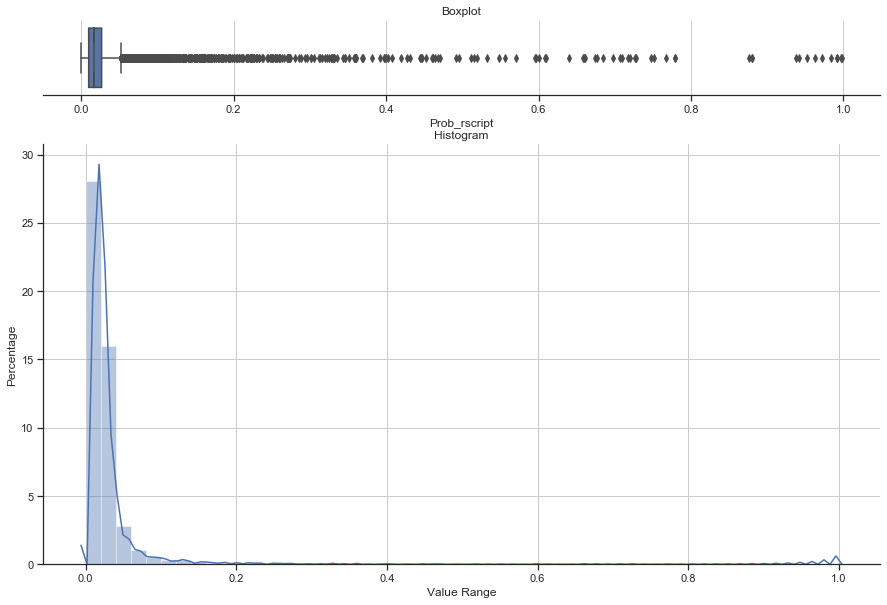

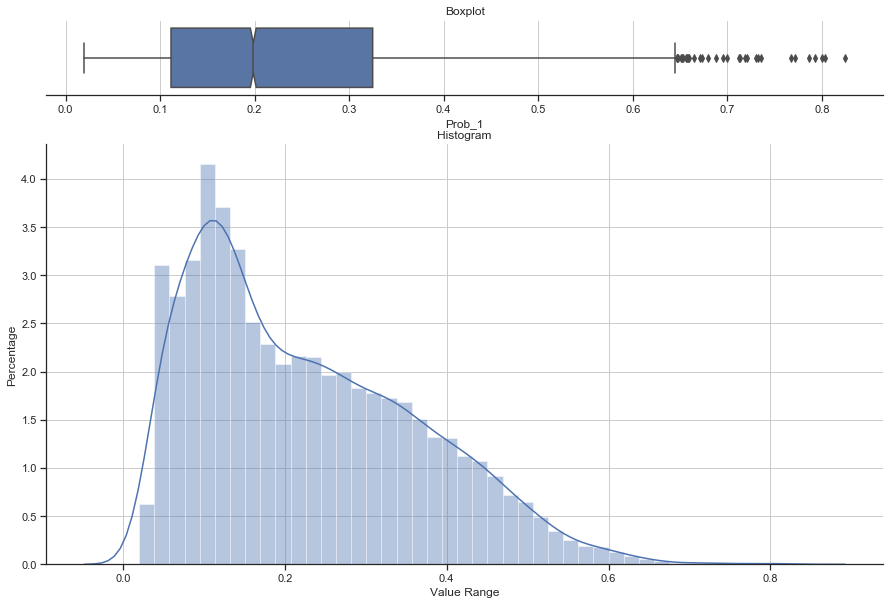

In [679]:
boxplot_histogram(comparision_df.loc[:,"Prob_rscript"])
boxplot_histogram(comparision_df.loc[:,"Prob_1"])

# Performance based on Cutoff

In [680]:
cutoffs = pd.Series(np.arange(0,1,0.001))

In [681]:
def success_sum(cutoff,model):
    row_select = comparision_df.loc[:,model] >= cutoff
    return comparision_df.loc[row_select,"Netto"].sum()
    

In [682]:
rebuild_series = cutoffs.map(lambda x: success_sum(x,model="Prob_1"))
rscript_series = cutoffs.map(lambda x: success_sum(x,model="Prob_rscript"))

In [683]:
import matplotlib
import matplotlib.pyplot as plt

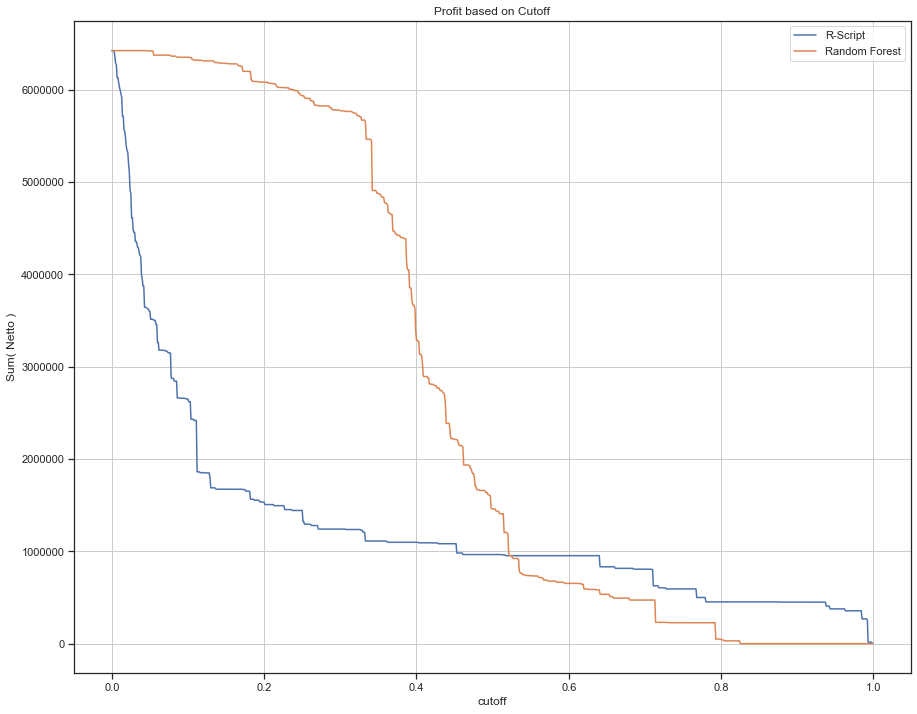

In [684]:
fig, ax = plt.subplots(figsize=(15,12))


ax.plot(cutoffs, rscript_series,label="R-Script")
ax.plot(cutoffs, rebuild_series,label="Random Forest")

ax.set(xlabel='cutoff', ylabel='Sum( Netto )',
       title='Profit based on Cutoff')
ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

In [685]:
total = comparision_df.loc[:,"Netto"].sum()
print("AUC, rscript:", np.sum(0.001*rscript_series)/total)
print("AUC, rebuild:", np.sum(0.001*rebuild_series)/total)

AUC, rscript: 0.19570244482907834
AUC, rebuild: 0.4287541546684765


# Performance: Cummulative Netto Sum based on Number of selected customers

In [687]:
rscript_cumsum_series = comparision_df.sort_values("Prob_rscript",ascending=False).loc[:,"Netto"].cumsum()
rebuild_cumsum_series = comparision_df.sort_values("Prob_1",ascending=False).loc[:,"Netto"].cumsum()

In [688]:
#rscript_cumsum_series
#rebuild_cumsum_series
number_contacts = pd.Series(np.arange(1,len(rscript_cumsum_series)+1,1))

In [689]:
comparision_df.shape

(11671, 6)

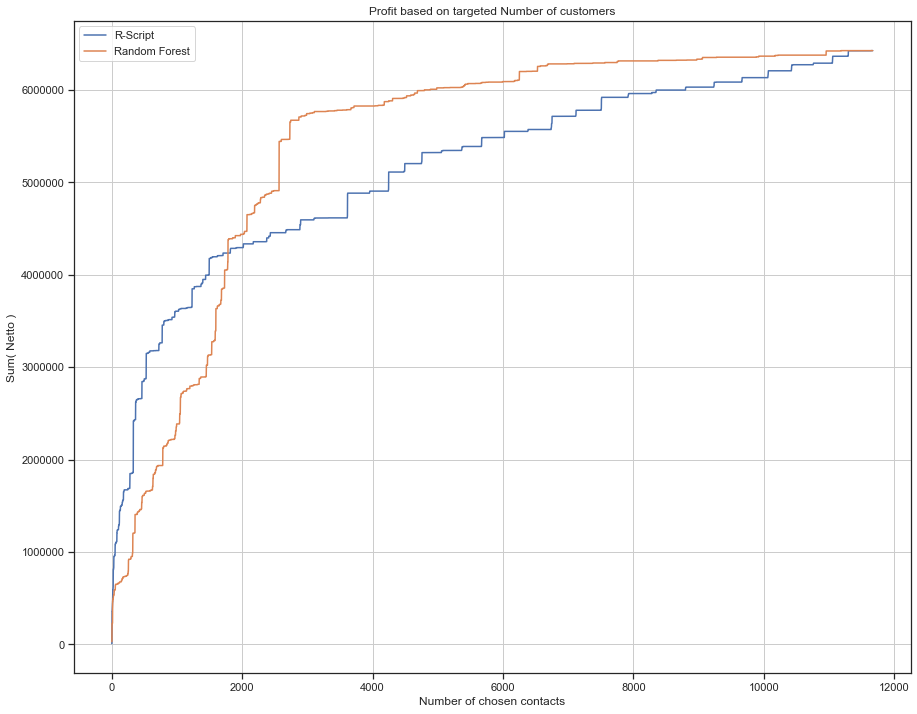

In [690]:
fig, ax = plt.subplots(figsize=(15,12))


ax.plot(number_contacts, rscript_cumsum_series,label="R-Script")
ax.plot(number_contacts, rebuild_cumsum_series,label="Random Forest")

ax.set(xlabel='Number of chosen contacts', ylabel='Sum( Netto )',
       title='Profit based on targeted Number of customers')
ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

In [696]:
number_rscript = (
    comparision_df
    .sort_values("Prob_rscript",ascending=False)
    .loc[:,"Netto"]
    .map(lambda x: int(bool(x)))
    .cumsum()
    .reset_index(inplace=False)
    .loc[:,"Netto"]
    )

In [697]:
number_rebuild = (
    comparision_df
    .sort_values("Prob_1",ascending=False)
    .loc[:,"Netto"]
    .map(lambda x: int(bool(x)))
    .cumsum()
    .reset_index(inplace=False)
    .loc[:,"Netto"]
    )

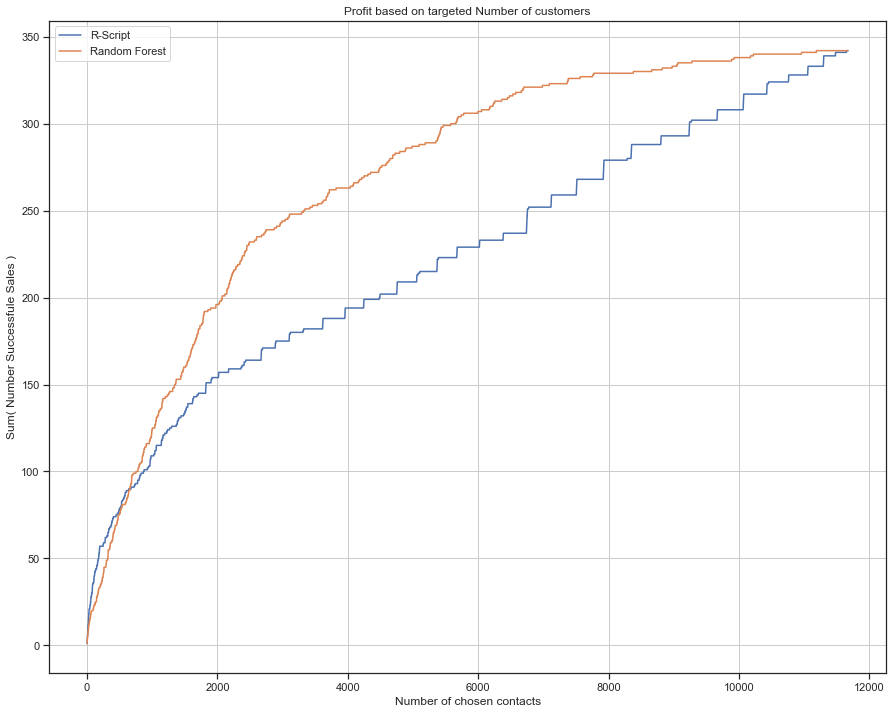

In [698]:
fig, ax = plt.subplots(figsize=(15,12))


ax.plot(number_contacts, number_rscript,label="R-Script")
ax.plot(number_contacts, number_rebuild,label="Random Forest")

ax.set(xlabel='Number of chosen contacts', ylabel='Sum( Number Successfule Sales )',
       title='Profit based on targeted Number of customers')
ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

In [699]:
print(134.9/3)
print(170/3)

44.96666666666667
56.666666666666664


In [700]:
len(number_contacts)

11671

In [701]:
print("AUC (percentage):")
print(f"Rebuild:  {number_rebuild.sum() / (number_rscript.max()*number_contacts.max() - number_rscript.max()**2/2 )}"[:15])
print(f"R-Script: {number_rscript.sum() / (number_rscript.max()*number_contacts.max() - number_rscript.max()**2/2 )}"[:15])



AUC (percentage):
Rebuild:  0.803
R-Script: 0.665


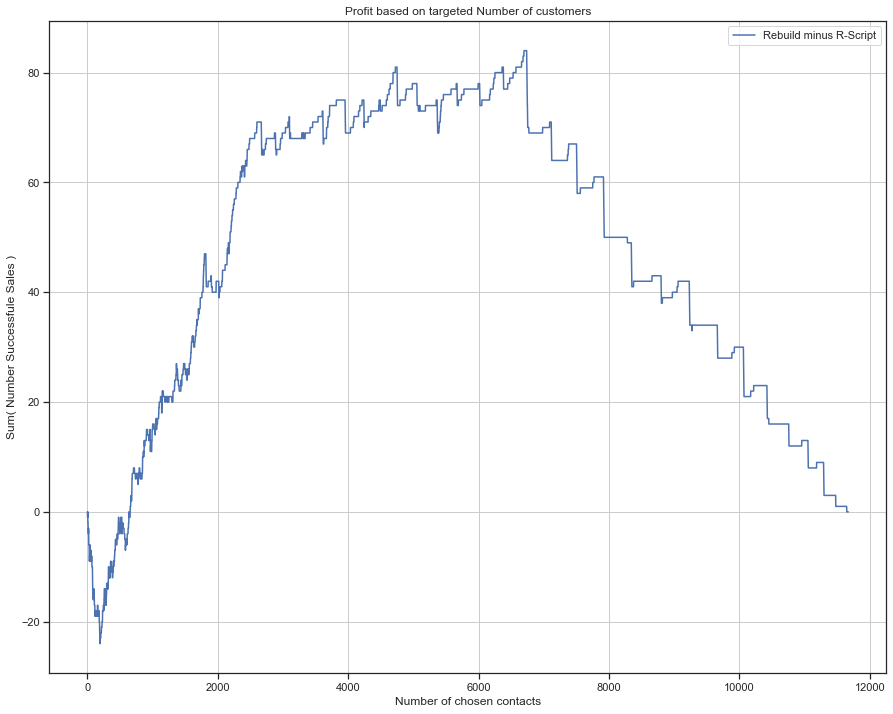

In [702]:
fig, ax = plt.subplots(figsize=(15,12))


ax.plot(number_contacts, number_rebuild-number_rscript,label="Rebuild minus R-Script")


ax.set(xlabel='Number of chosen contacts', ylabel='Sum( Number Successfule Sales )',
       title='Profit based on targeted Number of customers')
ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

- It's rather unlikely to contact 6000 customers.
- It has to be taken into respect of how many active VKbers are employed, and deduce from this a feasible number of customers

## Number of Vkbers

In [703]:
vkprog_raw.head(3)

,MA_ID,KOMBI_NAME,E_MAIL,KURZZEICHEN,FUNKTION,KAM
0,125,Schnyder Bernhard,bernhard.schnyder@apgsga.ch,ABS,Key Account Management,True
1,15505,Coralic Alma,alma.coralic@apgsga.ch,ACO,Verkaufsberatung Ost Aussendienst,False
2,155,Steltzlen Andreas,andreas.steltzlen@apgsga.ch,AST,Leitung Verkaufsberatung Bern Mitte,False


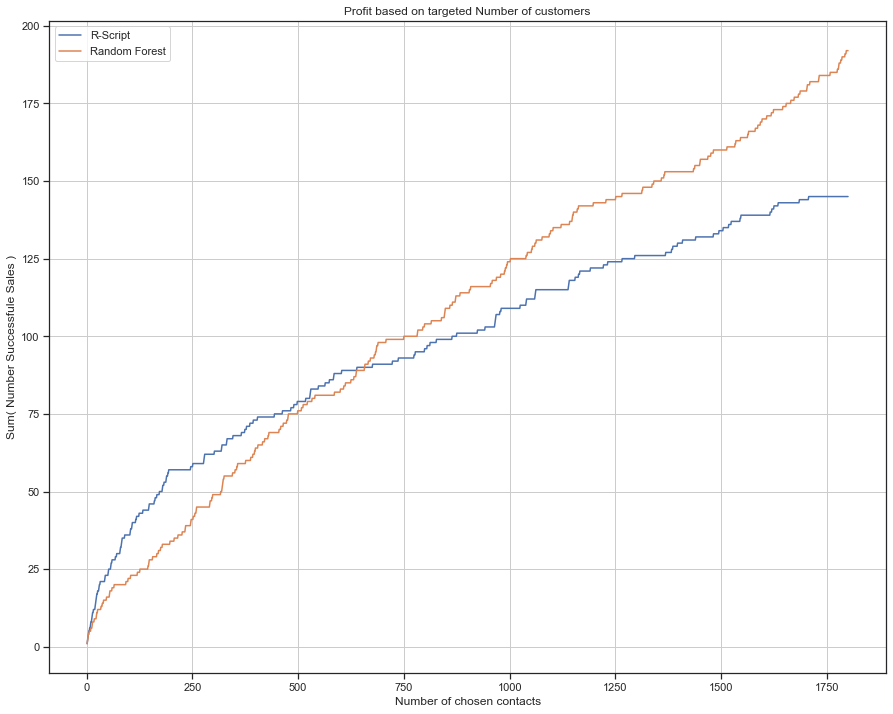

In [706]:
num_vkbers = len(set(vkprog_raw.loc[:,"KURZZEICHEN"]))
per_vkber  = 20 # Average number of contact that should be given to a VKber
total_max_num = num_vkbers*per_vkber



fig, ax = plt.subplots(figsize=(15,12))


ax.plot(number_contacts[:total_max_num],
        number_rscript[:total_max_num],
        label="R-Script"
       )

ax.plot(number_contacts[:total_max_num],
        number_rebuild[:total_max_num],
        label="Random Forest"
       )

ax.plot()

ax.set(xlabel='Number of chosen contacts',
       ylabel='Sum( Number Successfule Sales )',
       title='Profit based on targeted Number of customers')
ax.grid()

#fig.savefig("test.png")
plt.legend(loc=0)
plt.show()

# Sandbox

In [708]:
number_contacts[(number_rebuild == number_rscript)]

0            1
1            2
2            3
3            4
5            6
637        638
656        657
11646    11647
11647    11648
11648    11649
11649    11650
11650    11651
11651    11652
11652    11653
11653    11654
11654    11655
11655    11656
11656    11657
11657    11658
11658    11659
11659    11660
11660    11661
11661    11662
11662    11663
11663    11664
11664    11665
11665    11666
11666    11667
11667    11668
11668    11669
11669    11670
11670    11671
dtype: int32

In [710]:
number_rscript[(number_rebuild == number_rscript)]

0          1
1          2
2          3
3          4
5          5
637       89
656       90
11646    342
11647    342
11648    342
11649    342
11650    342
11651    342
11652    342
11653    342
11654    342
11655    342
11656    342
11657    342
11658    342
11659    342
11660    342
11661    342
11662    342
11663    342
11664    342
11665    342
11666    342
11667    342
11668    342
11669    342
11670    342
Name: Netto, dtype: int64